# Data Analyst Professional Practical Exam Submission

**You can use any tool that you want to do your analysis and create visualizations. Use this template to write up your summary for submission.**

You can use any markdown formatting you wish. If you are not familiar with Markdown, read the [Markdown Guide](https://s3.amazonaws.com/talent-assets.datacamp.com/Markdown+Guide.pdf) before you start.


# 📝 Task List

Your written report should include written text summaries and graphics of the following:
- Data validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Definition of a metric for the business to monitor  
  - How should the business use the metric to monitor the business problem
  - Can you estimate initial value(s) for the metric based on the current data
- Final summary including recommendations that the business should undertake

*Start writing report here..*

## Importing datasets and libraries. 

In [1]:
!pip install statsmodels==0.13.5

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.formula.api as smf

# Data Validation

Initially, the dataset contains 15,000 rows and 8 columns. The columns are: 

In [3]:
# Loading the dataset 
sales = pd.read_csv('product_sales.csv')
display(sales)

# Checking the datatypes if it matches what was described in the request. 
print('Data types of each column:')
print(sales.dtypes)

# Checking the shape of the dataset. 
print('Dataframe shape:', sales.shape)


,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois
...,...,...,...,...,...,...,...,...
14995,4,Call,17267b41-d048-4346-8b90-7f787690a836,10,50.82,0,22,Pennsylvania
14996,5,Call,09e10d6f-4508-4b27-895e-4db11ce8302b,10,52.33,1,27,Kansas
14997,1,Call,839653cb-68c9-48cb-a097-0a5a3b2b298b,7,34.87,4,22,West Virginia
14998,6,Call,e4dad70a-b23b-407c-8bd3-e32ea00fae17,13,64.90,2,27,New Jersey


Data types of each column:
week                   int64
sales_method          object
customer_id           object
nb_sold                int64
revenue              float64
years_as_customer      int64
nb_site_visits         int64
state                 object
dtype: object
Dataframe shape: (15000, 8)


## week: 
- There are 6 unique values. All are integers as described in the request. Values go from 1 to 6. No missing values and no cleaning needed. 

In [4]:
sorted(sales['week'].unique())

[1, 2, 3, 4, 5, 6]

## sales_method: 
- There are 5 unique values which is not what was described in the request. Upon checking, it appears that there are misspelled values.

In [5]:
sorted(sales['sales_method'].unique())

['Call', 'Email', 'Email + Call', 'em + call', 'email']

-  I changed **_'em + call'_** to **_'Email + Call'_**, and **_'email'_** to **_'Email'_**. 

In [6]:
sales['sales_method'].replace(['em + call', 'email'], ['Email + Call', 'Email'], inplace=True)
sales['sales_method'].unique()

array(['Email', 'Email + Call', 'Call'], dtype=object)

## customer_id: 
- There are 15,000 unique values. All values are in characters data type as described in the request. No missing values, no cleaning needed.

In [7]:
len(sales['customer_id'].unique())

15000

## nb_sold: 
- There are 10 unique values. All are integers as described in the request. Values go from 7 to 16. No missing values, no cleaning needed.

In [8]:
sorted(sales['nb_sold'].unique())

[7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [9]:
sales[['nb_sold']].describe()

,nb_sold
count,15000.000000
mean,10.084667
std,1.812213
min,7.000000
25%,9.000000
50%,10.000000
75%,11.000000
max,16.000000


## revenue: 
- There are 1074 missing values. Values are in decimal as described in the request. 

In [10]:
sales.isna().sum()

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64

- For the missing values, since `nb_sold` has a strong relationship with revenue as shown in the scatter plot which is also proven by their correlation coefficient, we can create a model to estimate the revenue based on `nb_sold`.

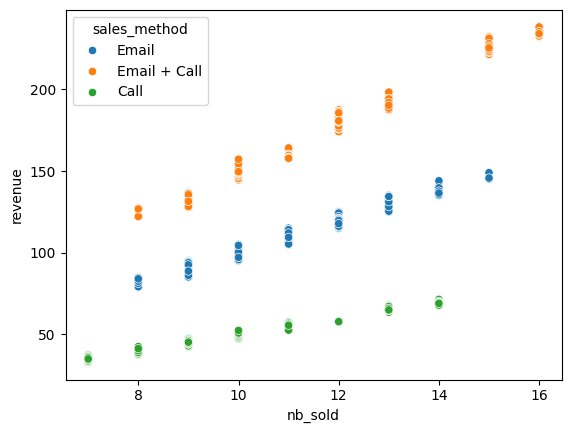

In [11]:
sns.scatterplot(data = sales, x= 'nb_sold', y='revenue', hue = 'sales_method')
plt.show()

In [12]:
sales.groupby('sales_method')[['nb_sold', 'revenue']].corr().iloc[1::2, :1]

,,nb_sold
sales_method,,
Call,revenue,0.985880
Email,revenue,0.967843
Email + Call,revenue,0.989591


In [13]:
# Splitting the dataframe between those rows that has revenue and missing revenue.
sales_train = sales[~sales['revenue'].isnull()]
sales_predict = sales[sales['revenue'].isnull()]

# Creating a linear regression model based on nb_sold, grouped by sales_method.
model = smf.ols('revenue ~ nb_sold + C(sales_method)', data = sales_train).fit()

# Using the model to predict the missing values. 
results = model.predict(sales_predict)

# Imputing the nulls with the predicted values. 
sales['revenue'] = sales['revenue'].fillna(results)

# Checking if there are still null values. 
sales.isnull().sum()

week                 0
sales_method         0
customer_id          0
nb_sold              0
revenue              0
years_as_customer    0
nb_site_visits       0
state                0
dtype: int64

- Checking if the predicted values go correctly based on the trend of the `nb_sold` and `revenue` across each `sales_method`s.

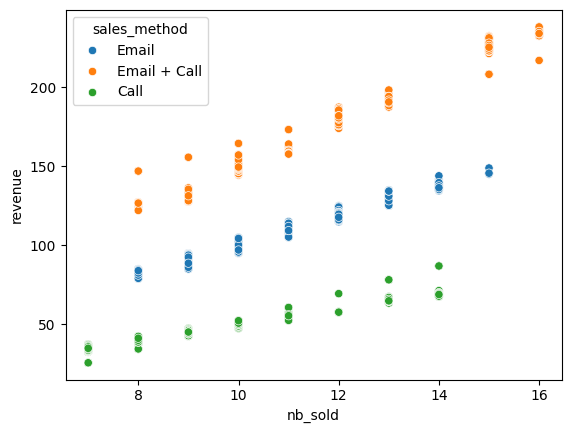

In [14]:
sns.scatterplot(data = sales, x= 'nb_sold', y='revenue', hue = 'sales_method')
plt.show()

- Checking for the outliers, I noticed that there are values beyond the upper bound for all sales methods and there is a velue below the lower bound for the Email + Call method. Since these data are revenues, it is best to cap the data with the lower or upper bound to minimize introducing biases. 

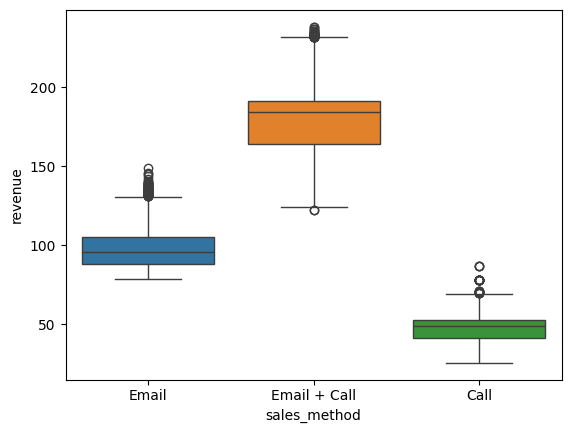

In [15]:
sns.boxplot(x='sales_method', y= 'revenue', hue = 'sales_method' ,data=sales)
plt.show()

- To cap the outliers, I collect first all the outliers for each sales method.

In [16]:
# Function to extract the outliers.
def outliers(data, method):
    method_dict = data.to_dict()
    q3 = sales[sales['sales_method']==method]['revenue'].quantile(0.75)
    q1 =  sales[sales['sales_method']==method]['revenue'].quantile(0.25)
    iqr = q3-q1
    upb = q3 +  (1.5 * iqr)
    lb = q1 - (1.5 * iqr)
    outliers = {i: k for (i, k) in method_dict.items() if k > upb or k < lb}
    return outliers, upb, lb

# Function to replace the outliers with either the upper or lower bound.
def replace(data, upb, lb):
    for i, j in data.items(): 
        if j > upb: 
            data[i] = upb
        else:
            data[i] = lb
    return data

In [17]:
# Getting the outliers for each sales methods
email_outliers, email_upb, email_lb = outliers(sales[sales['sales_method']=='Email']['revenue'], 'Email')
print('There are', len(email_outliers), 'outliers in the Email method. \nThe outliers for Email method are:\n', email_outliers.values(), '\n')

call_outliers, call_upb, call_lb = outliers(sales[sales['sales_method']=='Call']['revenue'], 'Call')
print('There are', len(call_outliers), 'outliers in the Call method. \nThe outliers for Call method are:\n', call_outliers.values(), '\n')

email_call_outliers, email_call_upb, email_call_lb = outliers(sales[sales['sales_method']=='Email + Call']['revenue'], 'Email + Call')
print('There are', len(email_call_outliers), 'outliers in the Email + Call method. \nThe outliers for Email + Call method are:\n', email_call_outliers.values())



There are 88 outliers in the Email method. 
The outliers for Email method are:
 dict_values([132.01, 133.26, 133.3, 134.55578225920476, 133.59, 135.42, 132.26, 141.84, 131.19, 131.36, 131.65, 133.07, 135.66, 135.46, 136.62, 140.66, 134.47, 135.81, 139.22, 138.09, 136.34, 134.09, 132.52, 132.44, 139.2, 132.18, 133.22, 131.91, 131.2, 131.66, 136.23, 131.74, 134.97, 131.59, 136.28, 133.09, 137.29, 138.12, 137.82, 133.82, 140.01, 133.47, 132.21, 144.01, 136.83, 134.95, 139.16, 148.97, 132.12, 139.14, 131.88, 135.32, 133.09, 135.1, 135.98, 133.13, 132.41, 134.22, 131.97, 131.41, 131.75, 133.6, 145.15, 133.15, 134.27, 132.55, 134.23, 133.27, 131.63, 135.43, 132.06, 145.71, 138.95, 134.11, 136.89, 133.38, 131.78, 137.14, 132.97, 133.08, 139.7, 132.23, 137.65, 131.71, 131.16, 134.39, 136.47, 134.37]) 

There are 32 outliers in the Call method. 
The outliers for Call method are:
 dict_values([86.96932912052657, 70.31, 78.21819604171517, 70.16, 71.04, 78.21819604171517, 78.21819604171517, 78.218

In [18]:
# Replacing the outliers with the upper or lower bound. 
replacement = replace(email_outliers, email_upb, email_lb)
replacement.update(replace(call_outliers, call_upb, call_lb))
replacement.update(replace(email_call_outliers, email_call_upb, email_call_lb))


In [19]:
# Updating the dataframe with the corrected values for revenue. 
sales['revenue'].update(pd.Series(replacement))

- Rounding the revenue to 2 decimal places as requested. 

In [20]:
sales['revenue'].round(2)

0         99.55
1        225.47
2         52.55
3        108.30
4         90.49
          ...  
14995     50.82
14996     52.33
14997     34.87
14998     64.90
14999    190.77
Name: revenue, Length: 15000, dtype: float64

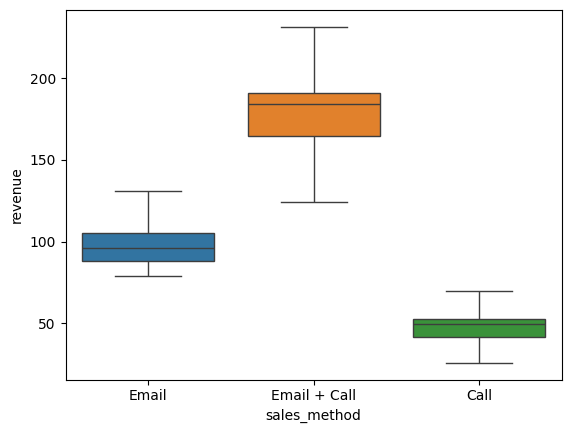

In [21]:
# Checking if there are still outliers.
sns.boxplot(x='sales_method', y= 'revenue', hue = 'sales_method' ,data=sales)
plt.show()

- We have successfully removed all outliers in each sales methods!

## years_as_customer
- There are 42 unique values. The max values is 63 which is not right since the company was founded in 1984 and that makes the company 40 years old at most. This could be an input error and may be omitted if it is an isolated case. 

In [22]:
len(sales['years_as_customer'].unique())

42

In [23]:
sales[['years_as_customer']].describe()

,years_as_customer
count,15000.000000
mean,4.965933
std,5.044952
min,0.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,63.000000


- Checking if there are other values that goes beyond 40 years. 

In [24]:
sales[sales['years_as_customer']>=40]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


- Since there are only two cases where the number of years as customer goes beyond 40, we can delete these entries. 

In [25]:
# Omitting the outliers in the year_as_customer column. 
sales = sales[sales['years_as_customer']<40]

## nb_site_visits
- There are 27 unique values. Values go from 12 to 41. Values are in integer. There are no outliers. No cleaning needed.

In [26]:
len(sales['nb_site_visits'].unique())

27

In [27]:
sales[['nb_site_visits']].describe()

,nb_site_visits
count,14998.000000
mean,24.990799
std,3.501100
min,12.000000
25%,23.000000
50%,25.000000
75%,27.000000
max,41.000000


## state
- There are 50 unique values. All are in character data type as described. No missing values, no cleaning needed. 

In [28]:
sales['state'].value_counts()

California        1870
Texas             1187
New York           965
Florida            904
Illinois           617
Pennsylvania       598
Ohio               566
Michigan           498
Georgia            489
North Carolina     459
New Jersey         434
Virginia           372
Indiana            354
Tennessee          340
Washington         335
Arizona            321
Missouri           311
Massachusetts      294
Maryland           263
Wisconsin          253
Minnesota          245
Colorado           230
Louisiana          230
Oregon             229
South Carolina     224
Alabama            214
Kentucky           213
Oklahoma           196
Connecticut        179
Iowa               165
Kansas             142
Mississippi        139
Arkansas           132
Utah               124
Nevada             102
Nebraska            91
West Virginia       85
New Mexico          84
Hawaii              72
Maine               63
Idaho               62
New Hampshire       53
Montana             45
Rhode Islan

In [29]:
len(sales['state'].unique())

50

In [30]:
sales.shape

(14998, 8)

## Summary of Data Validation: 
- **week:** There are 6 unique values. All are integers as described in the request. Values go from 1 to 6. No missing values and no cleaning needed. 
- **sales_method:** There are 5 unique values which is not what was described in the request. Upon checking, it appears that there are misspelled values. I changed **_'em + call'_** to **_'Email + Call'_**, and **_'email'_** to **_'Email'_**. 
- **customer_id:** There are 15,000 unique values. All values are in characters data type as described in the request. No missing values, no cleaning needed.
- **nb_sold:** There are 10 unique values. All are integers as described in the request. Values go from 7 to 16. No missing values, no cleaning needed.
- **revenue:** There are 1074 missing values. Values are in decimal as described in the request. For the missing values, since nb_sold has a strong relationship with revenue, I created a linear regression model to impute the missing values. I also found out that there are outliers in each sales method. I replaced the outliers with the max or min revenue depending on the sales method. Lastly, I rounded the values in 2 decimal places as described in the request. 
- **years_as_customer:** There are 42 unique values. The max values is 63 which is not right since the company was founded 1984 and that makes the company 40 years old at most. This could be an input error and may be omitted if it is an isolated case.
- **nb_site_visits:** There are 27 unique values. Values go from 12 to 41. Values are in integer. There are no outliers. No cleaning needed.
- **state:** There are 50 unique values. All are in character data type as described. No missing values, no cleaning needed. 

After all the cleaning, we ended with a dataset of 14998 rows and 8 columns. 

I also took the liberty of getting an overview of the distribution of each column. The result is as follows.

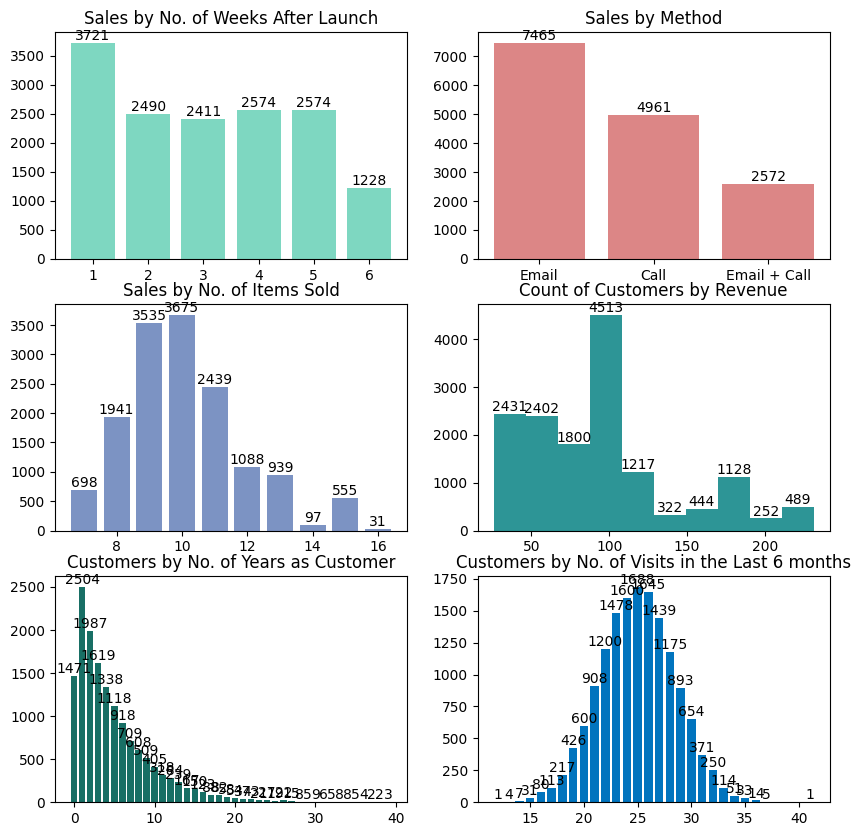

In [31]:
# Preparing the data for visualization. 
sales_by_week = sales[['week', 'customer_id']].groupby(['week']).count()
sales_by_method = sales[['sales_method', 'customer_id']].groupby(['sales_method']).count().sort_values('customer_id', ascending=False)
sales_by_sold = sales[['nb_sold', 'customer_id']].groupby(['nb_sold']).count()
customer_by_year = sales[['years_as_customer', 'customer_id']].groupby(['years_as_customer']).count()
customer_by_nbvisits = sales[['nb_site_visits', 'customer_id']].groupby(['nb_site_visits']).count()

# Visualizations
fig, ax = plt.subplots(3,2, figsize=(10, 10))

freq, bin_edges = np.histogram(sales['revenue'], bins=10)



chart1 = ax[0,0].bar(sales_by_week.index, sales_by_week['customer_id'], color = '#7ED7C1' )
chart2 = ax[0,1].bar(sales_by_method.index, sales_by_method['customer_id'], color = '#DC8686' )
chart3 = ax[1,0].bar(sales_by_sold.index, sales_by_sold['customer_id'], color = '#7C93C3')
chart4 = ax[1,1].hist(sales['revenue'], bins = bin_edges, color = '#2D9596')
chart5 = ax[2,0].bar(customer_by_year.index, customer_by_year['customer_id'], color = '#186F65')
chart6 = ax[2,1].bar(customer_by_nbvisits.index, customer_by_nbvisits['customer_id'], color = '#0174BE')

ax[0,0].set_title('Sales by No. of Weeks After Launch')
ax[0,1].set_title('Sales by Method')
ax[1,0].set_title('Sales by No. of Items Sold')
ax[1,1].set_title('Count of Customers by Revenue')
ax[2,0].set_title('Customers by No. of Years as Customer')
ax[2,1].set_title('Customers by No. of Visits in the Last 6 months')

ax[0,0].bar_label(chart1)
ax[0,1].bar_label(chart2)
ax[1,0].bar_label(chart3)
for i, j in zip(ax[1,1].patches, freq): 
    height = i.get_height()
    ax[1,1].text(i.get_x()+i.get_width() /2, height + 0.01, j, ha = 'center', va='bottom')
ax[2,0].bar_label(chart5)
ax[2,1].bar_label(chart6)

plt.show()

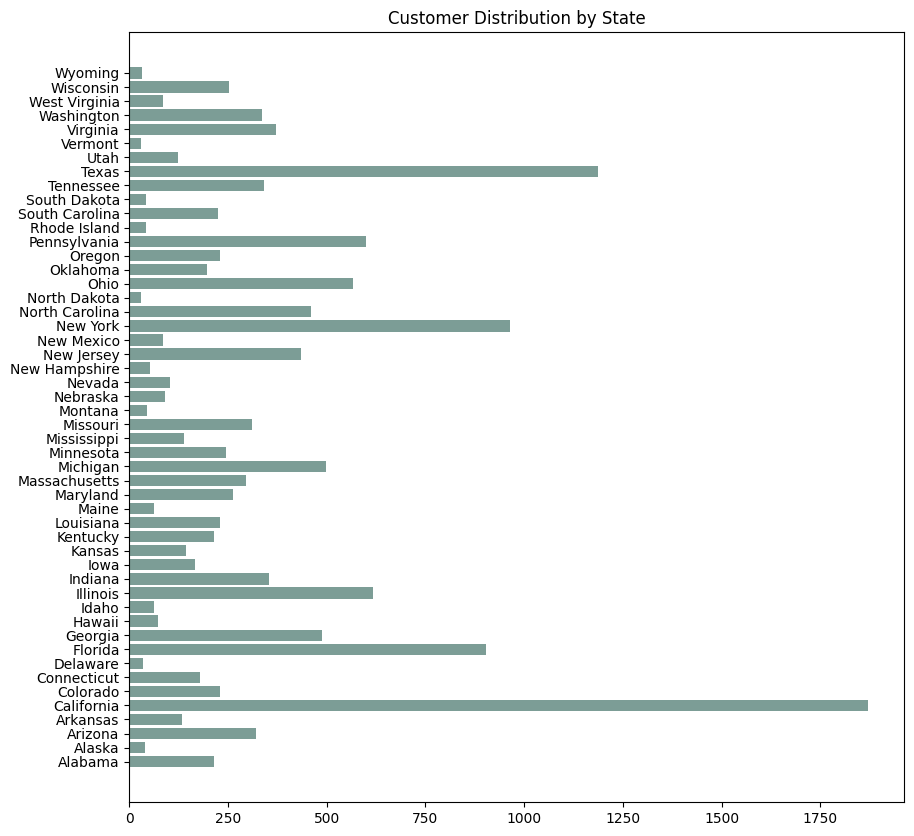

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
customer_by_state = sales[['state', 'customer_id']].groupby(['state']).count().reset_index().sort_values('state', ascending=True)
ax.barh(customer_by_state.index, customer_by_state['customer_id'], color ='#7C9D96')
ax.set_yticks(customer_by_state.index)
ax.set_yticklabels(customer_by_state['state'])
ax.set_title('Customer Distribution by State')

plt.show()

# Data Analysis

## Question 1: How many customers were there for each approach?
- The leading method in terms of number of customers is the Email method at 7465. It is followed by the Call method at 4961 and Email + Call being the last at 2572 customers only.

Text(0.5, 1.0, 'No. of Customer for each Method')

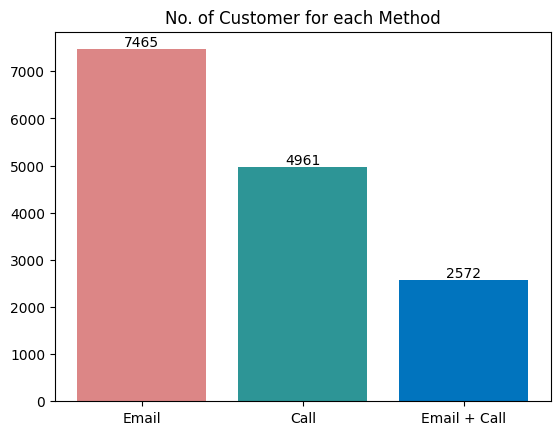

In [33]:
plt.bar_label(plt.bar(sales_by_method.index, sales_by_method['customer_id'], color = ['#DC8686', '#2D9596', '#0174BE']))
plt.title('No. of Customer for each Method')

## Question 2: What does the spread of the revenue look like overall? And for each method?
- Generally, the spread for each method is quite distinct. The distribution of the Call and Email methods are clustered at 50 and 100 respectively. Looking at their mean revenues, the Call method generated the lowest mean revenue at 47.62 USD per customer. 

- The Email & Call method has the most spread ranging from 124.14 to 231.55. This method has the lowest conversion at only 2572 customers. Surprisingly, it is also the method that generates the most revenue per customer amounting to 183.96 USD per customer.

- From this, we can infer that the number of customers does not automatically mean high returns. The Email + Call method has the lowest number of customers but it has the highest revenue per customer. 

In [34]:
sales.groupby('sales_method')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
sales_method,,,,,,,,
Call,4961.0,47.629494,8.819323,25.711398,41.460000,49.26,52.700,69.560000
Email,7465.0,97.135476,10.987135,78.830000,88.150000,95.79,105.300,131.015000
Email + Call,2572.0,183.959244,27.682311,124.141120,164.421448,184.50,191.275,231.555328


In [35]:
sales.groupby('sales_method')['revenue'].agg(['sum', 'count','mean', 'std'])

,sum,count,mean,std
sales_method,,,,
Call,236289.919451,4961,47.629494,8.819323
Email,725116.326347,7465,97.135476,10.987135
Email + Call,473143.174310,2572,183.959244,27.682311


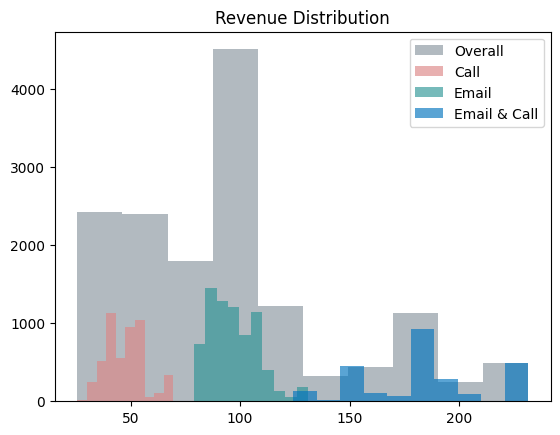

In [36]:
# Seperating the data by sales method. 
Call = sales[sales['sales_method']=='Call']
Email = sales[sales['sales_method']=='Email'].sort_values('week')
Email_Call = sales[sales['sales_method']=='Email + Call']

# Visualization
plt.hist(sales['revenue'], bins = 10,  alpha = 0.30, color='#001C30')
plt.hist(Call['revenue'], bins=10, alpha=0.65, color='#DC8686')
plt.hist(Email['revenue'], bins=10, alpha=0.65, color='#2D9596')
plt.hist(Email_Call['revenue'], bins=10, alpha=0.65, color='#0174BE')
plt.legend(['Overall', 'Call', 'Email', 'Email & Call'])
plt.title('Revenue Distribution')
plt.show()

## Question 3: Was there any difference in revenue over time for each of the methods?
- As shown in the line chart, the Email method started with the highest revenue on week 1 at almost 250000. However, its performance declined as weeks went on. 
- Meanwhile, the revenue under the Call method gradually increased reaching its peak at week 5. 
- Lastly, the Mixed method showed a promising performance as its revenue greatly increases over the weeks reaching its peak at Week 5. 
- Overall, I can say that the Email and Call method showed the best performance in terms of revenue and stability. 

Text(0.5, 1.0, 'Revenue over Time')

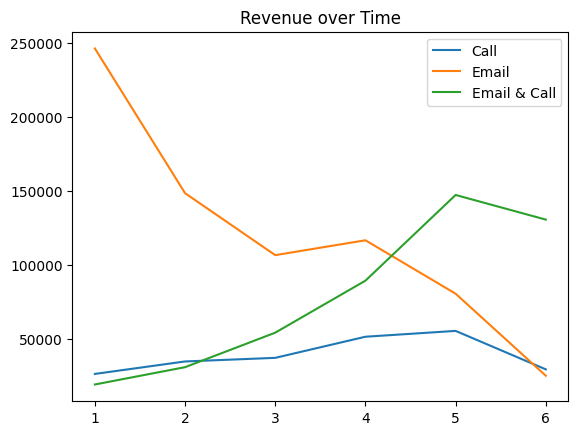

In [37]:
call_over_time = Call.groupby(['week'])['revenue'].sum().to_frame()
email_over_time = Email.groupby(['week'])['revenue'].sum().to_frame()
email_call_over_time = Email_Call.groupby(['week'])['revenue'].sum().to_frame()
plt.plot(call_over_time)
plt.plot(email_over_time)
plt.plot(email_call_over_time)
plt.legend(['Call', 'Email', 'Email & Call'])
plt.title('Revenue over Time')

- Looking at the Mean Revenue over time, each method showed an increasing trend but their difference is substantial. The Mixed method showed again the best performance among the three approaches. For the first three weeks, the Mixed method has about 50 USD advantage over the Email method which also has about 50 USD advantage over the Call method. But from week 4 onwards, the difference in mean revenue for the Mixed method and Email method still increased towards the end. 

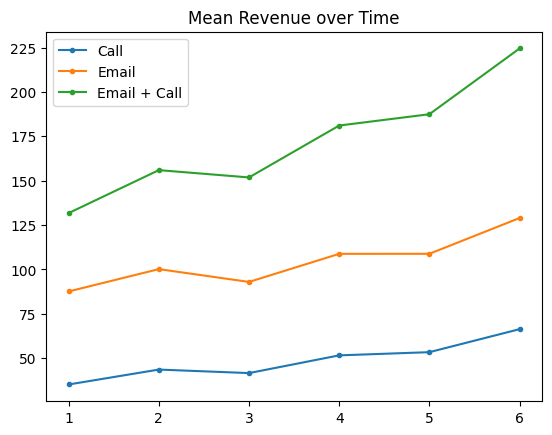

In [38]:
# Getting the Mean Revenue
mean_revenue = sales.groupby(['week', 'sales_method'])['revenue'].mean().unstack(level='sales_method')

plt.plot(mean_revenue, marker = '.')
plt.legend(mean_revenue.columns)
plt.title('Mean Revenue over Time')
plt.show()


## Question 4: Based on the data, which method would you recommend we continue to use? Some of these methods take more time from the team so they may not be the best for us to use if the results are similar.

- At a glance, it is tempting to conclude that the Email method is the top-performing method based on revenue. However, when you look at the average revenue per customer, we can say that the Email and Call method drives more revenue per customer. Thus, this method is more valuable.

In [39]:
sales.groupby('sales_method')['revenue'].agg(['sum', 'count','mean'])

,sum,count,mean
sales_method,,,
Call,236289.919451,4961,47.629494
Email,725116.326347,7465,97.135476
Email + Call,473143.174310,2572,183.959244


I definitely recommend that we continue to use the Email + Call method. Based on the data, the revenue from this method tends to increase over time. Aside from that, the customer value from this method is significantly higher at about 180 USD.

I also advise that we continue to use the Email method in the first four weeks after the product launch. If you look at the data, the Email method showed a good performance in terms of driving customers. In the fourth week, I suggest that we change the method from Email to Email and Call to avoid a drop in revenue from these customers.

Lastly, I advise that we stop the Call method due to poor mean revenue performance given that this method is the most demanding in the operations. I believe it is best to put our effort into the other methods instead. This will cut our production cost and we can potentially turn more customers from other methods.

## Business Metrics
With the goal of increasing revenue, I suggest that we monitor two metrics. 

- First is the number of customers. This metric is highly dependable on the marketing approach that we will develop. Should we decide to continue all three methods, here is the baseline that we can use.

In [40]:
sales.groupby('sales_method')['customer_id'].agg(['count'])

,count
sales_method,
Call,4961
Email,7465
Email + Call,2572


- Second is the revenue per customer. This metric is more reliable than the revenue which can be misleading at times. Here are the initial values for each method. 

In [41]:
sales.groupby('sales_method')['revenue'].agg(['mean'])

,mean
sales_method,
Call,47.629494
Email,97.135476
Email + Call,183.959244


- An increase on these values is an implication of progress.

# Recommendation
For the succeeding weeks, I recommend the following:
- Keep an eye on the two metrics: Number of Customers and Revenue per Customer.
- For the same product launch, I suggest that we discontinue the Email method because it is no longer driving as much revenue as it did in the first few weeks. I also suggest that we use this opportunity to pivot to the Email + Call method since they already received email before.
- On the next product launch, it is worth trying to only use the Email and Email + Call method. This will test if the company will survive without the call method. If so, we can decide to stop the Call method and save us some production costs.
- It is also wise to try other marketing strategies like Social media marketing which is so popular in the industry right now.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation